In [79]:
import math
import numpy as np
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.stats import poisson
from scipy.stats import binom
from patsy import dmatrices
import statsmodels.graphics.tsaplots as tsa
from matplotlib import pyplot as plt

In [137]:
cycle_data = pd.read_csv("FedCycleData071012.csv")

# Data Cleaning

In [138]:
## fill empty `EstimatedDayOfOvulation` with mean for that individual
replace_str = cycle_data.at[1639,'EstimatedDayofOvulation']
cycle_data['EstimatedDayofOvulation'].replace(replace_str,np.nan,inplace=True)
cycle_data['EstimatedDayofOvulation'].replace([np.inf, -np.inf], np.nan, inplace=True)
cycle_data['EstimatedDayofOvulation'] = cycle_data['EstimatedDayofOvulation'].astype(float)
cycle_data['EstimatedDayofOvulation'] = cycle_data['EstimatedDayofOvulation'].fillna(cycle_data.groupby('ClientID')['EstimatedDayofOvulation'].transform('mean'))

# if there are extra NaNs, replace those with the mean for the dataset
cycle_data['EstimatedDayofOvulation'].fillna(cycle_data['EstimatedDayofOvulation'].mean(),inplace=True)
cycle_data['EstimatedDayofOvulation'] = cycle_data['EstimatedDayofOvulation'].round(0).astype(int)

In [217]:
data = cycle_data.loc[df["ClientID"] == 'nfp8122']


In [218]:
data["Const"] = 1

In [219]:
X = data[['Const','LengthofLutealPhase','LengthofMenses',"TotalMensesScore","TotalFertilityFormula","EstimatedDayofOvulation"]]
y = data["LengthofCycle"]

In [220]:
X["LengthofLutealPhase"] = y - X["EstimatedDayofOvulation"]

In [221]:
cols = ['Const','LengthofLutealPhase','LengthofMenses',"TotalMensesScore","TotalFertilityFormula","EstimatedDayofOvulation"]
for col in cols:
    X[col] = X[col].astype(int)

In [ ]:
#offset for algorihm

In [222]:
X = X[0:-1]
y = y[1:]

In [ ]:
#train test split

In [260]:
X_train, X_test = np.array(X[:37]), np.array(X[37:])

y_train, y_test = np.array(y[:37]).reshape(-1,1), np.array(y[37:]).reshape(-1,1)

In [330]:
class PoissonINAR(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(PoissonINAR, self).__init__(endog, exog, **kwds)

    def nloglikeobs(self, params):
        #Fetch the parameters gamma and beta that we would be optimizing
        x = len(params)
        gamma = .01*params[-1]
        beta = .01*np.ones(x-1)
        beta = np.array([.01,.05,.03,.07,.05,.02])
        
        #Set y and X
        y = self.endog
        y = np.array(y)
        X = self.exog
       
        #Compute rho as a function of gamma
        rho = 1.0/(1.0+math.exp(-gamma))
        
        #Compute the Poisson mean mu as a dot product of X and Beta
        mu = np.exp(X.dot(beta))
        #print(mu)
        #Init the list of loglikelihhod values, one value for each y
        ll = []
        #Compute all the log-likelihood values for the Poisson INAR(1) model
        for t in range(len(y)-1,0,-1):
            prob_y_t = 0
            for j in range(int(min(y[t], y[t-1])+1)):
                l = binom.pmf(j, y[t-1], rho)
                #print(y[t] - j, mu[t])
                m = poisson.pmf((y[t]-j), mu[t])
                #print(l)
                #print(m)
                prob_y_t += m * l
                
            ll.append(math.log(prob_y_t))
        ll = np.array(ll)
        #print('gamma='+str(gamma) + ' rho='+str(rho) + ' beta='+str(beta) + ' ll='+str(((-ll).sum(0))))
        #return the negated array of  log-likelihood values
        return -ll

    def fit(self, start_params=None, maxiter=1000, maxfun=5000, **kwds):
        #Add the gamma parameter to the list of exogneous variables that
        # the model will optimize
        self.exog_names.append('gamma')
        if start_params == None:
            #Start with some initial values of Beta and gamma
            start_params = np.append(np.ones(self.exog.shape[1]), 1.0)
        #Call super.fit() to start the training
        return super(PoissonINAR, self).fit(start_params=start_params,
            maxiter=maxiter, maxfun=maxfun, **kwds)

    def predict(self, params, exog=None, *args, **kwargs):
        #Fetch the optimized values of parameters gamma and beta
        fitted_gamma = params[-1]
        fitted_beta = params[:-1]
        X = np.array(exog)
        #Compute rho as a function of gamma
        rho = 1.0/(1.0+math.exp(-fitted_gamma))
        #Fetch the Intercept and the regression variables,
        # except for the last column which contains the lagged y values
        X = exog[:,:-1]
        
        #Fetch the lagged y values
        y_lag_1 = exog[:,-1]
        
        #Compute the predicted y using the Poisson INAR(1) model's equation
        y_pred = rho * y_lag_1 + np.exp(X.dot(fitted_beta))
        return y_pred

In [331]:
inar_model = PoissonINAR(y_train, X_train)
inar_model_results = inar_model.fit()

Optimization terminated successfully.
         Current function value: 2.565893
         Iterations: 186
         Function evaluations: 330


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [ ]:
#matrix for prediction

In [334]:
temp_X_test = np.zeros((7,7))
temp_X_test[:,:-1] = X_test
temp_X_test[:,-1] = y_test[0]

In [335]:
inar_predictions = np.round(inar_model_results.predict(exog=temp_X_test))

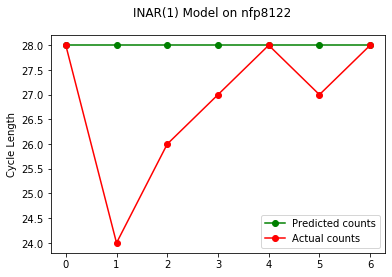

In [343]:
predicted_counts=inar_predictions
actual_counts = y_test.reshape(1,-1)[0]
fig = plt.figure(figsize = (6,4))
fig.suptitle("INAR(1) Model on nfp8122")
predicted, = plt.plot( predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot( actual_counts, 'ro-', label='Actual counts')
plt.ylabel("Cycle Length")
plt.legend(handles=[predicted, actual])
plt.savefig("INAR_nfp8122")
plt.show()
